# Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy

# Add the path to the CLI
sys.path.insert(0, os.path.abspath("../cli"))
#set environment variable
os.environ["OMP_NUM_THREADS"] = "8"

from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    positions_line,
    positions_half_circle,
)
from simulation.plotting import plot_velocity, plot_snapshot_and_signal
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)

#Devito configuration
configuration['log-level'] = 'DEBUG'
configuration['compiler'] = 'gcc-12'

In [2]:
# Simplest example - water with no object
domain_size = (60, 60) #60m by 60m domain
f0 = 5 #5kHz source
source_distance = 0.02 #separated by 2cm - default is 2mm
v_env = 1.5 #1.5km/s

sonar = Sonar(
        domain_size,
        f0,
        v_env,
        FlatBottom(),
        source_distance=source_distance,
        tn = 30/v_env)

ns = 128 #number of sources
cy = (ns - 1) / 2 * source_distance + source_distance #distance from top
sonar.set_source()

rec_args = {
    "name": "rec",
    "grid": sonar.model.grid,
    "time_range": sonar.time_range,
    "npoint": 180,
    "coordinates": positions_half_circle(domain_size[0] / 3, domain_size[1] / 2, cy, 180),
}
sonar.set_receiver("Receiver", rec_args)
sonar.finalize()

/Users/reguly/Work/sonar-FWI/notebooks


Operator `initdamp` generated in 0.17 s
  * lowering.Clusters: 0.08 s (48.7 %)
     * specializing.Clusters: 0.05 s (30.4 %)
  * lowering.IET: 0.06 s (36.5 %)
     * specializing.IET: 0.04 s (24.4 %)
Flops reduction after symbolic optimization: [72 --> 72]


gcc-12 -march=native -O3 -g -fPIC -Wall -std=c99 -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/e551f03f611560ac29aa78145a8cb991040fe1da.c -lm -o /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/e551f03f611560ac29aa78145a8cb991040fe1da.dylib


Operator `initdamp` jit-compiled `/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/e551f03f611560ac29aa78145a8cb991040fe1da.c` in 1.35 s with `GNUCompiler`
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.03, 1.24 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.45 GFlops/s, 0.00 GPts/s]
  * section2<254,1108> ran in 0.01 s [OI=0.69, 18.65 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,1108> ran in 0.01 s [OI=0.69, 37.76 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.45 GFlops/s, 0.00 GPts/s]
  * section6<254> ran in 0.01 s [OI=0.88, 1.78 GFlops/s, 0.00 GPts/s]
  * section7<<1108,254>,<1108,254>> ran in 0.01 s [OI=0.02, 15.92 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}
Allocating host memory for vp(1124, 1124) [10 MB]
Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for s

In [3]:
print(f"Wavelength in water: {v_env / f0} meters")
print(
    f"The computational grid has {sonar.model.grid.shape} grid points and physical size of {sonar.model.grid.extent} m. Spacing: {sonar.model.spacing_map} m."
)
print(f"The time step is {sonar.model.critical_dt} milliseconds, giving a samplig frequency of {1/sonar.model.critical_dt} kHz.")
print(f"End time: {sonar.time_range.stop} milliseconds. Time iterations: {sonar.time_range.num}")

Wavelength in water: 0.3 meters
The computational grid has (1108, 1108) grid points and physical size of (110.7, 110.7) m. Spacing: {h_x: 0.1, h_y: 0.1} m.
The time step is 0.005 milliseconds, giving a samplig frequency of 200.0 kHz.
End time: 20.0 milliseconds. Time iterations: 4001


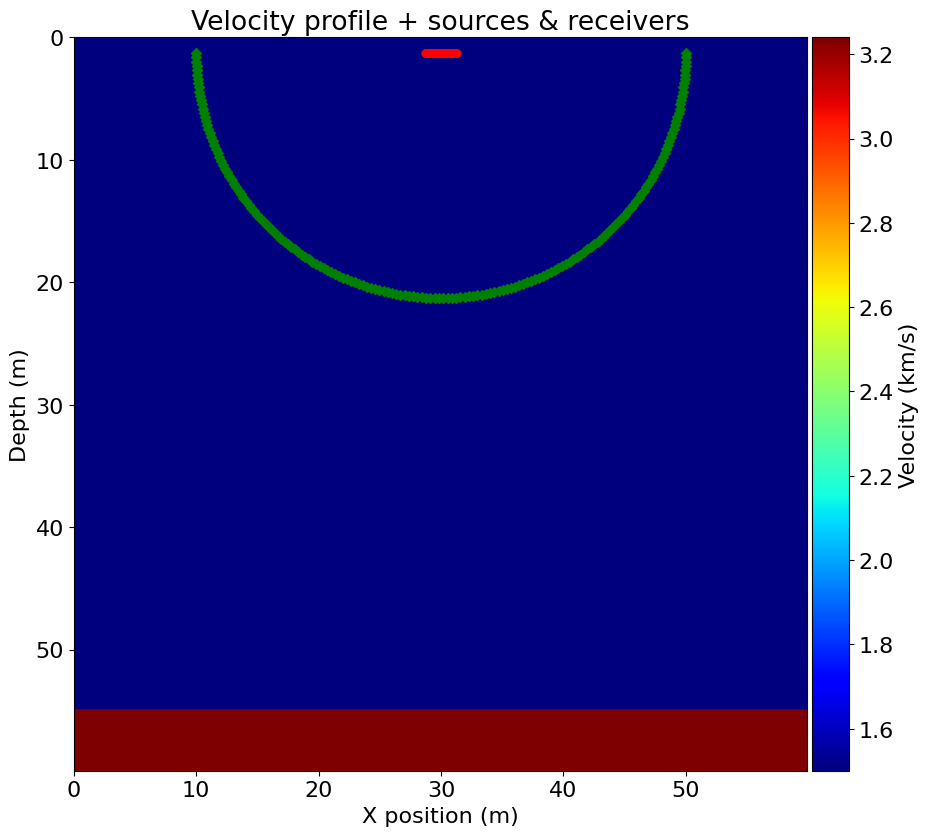

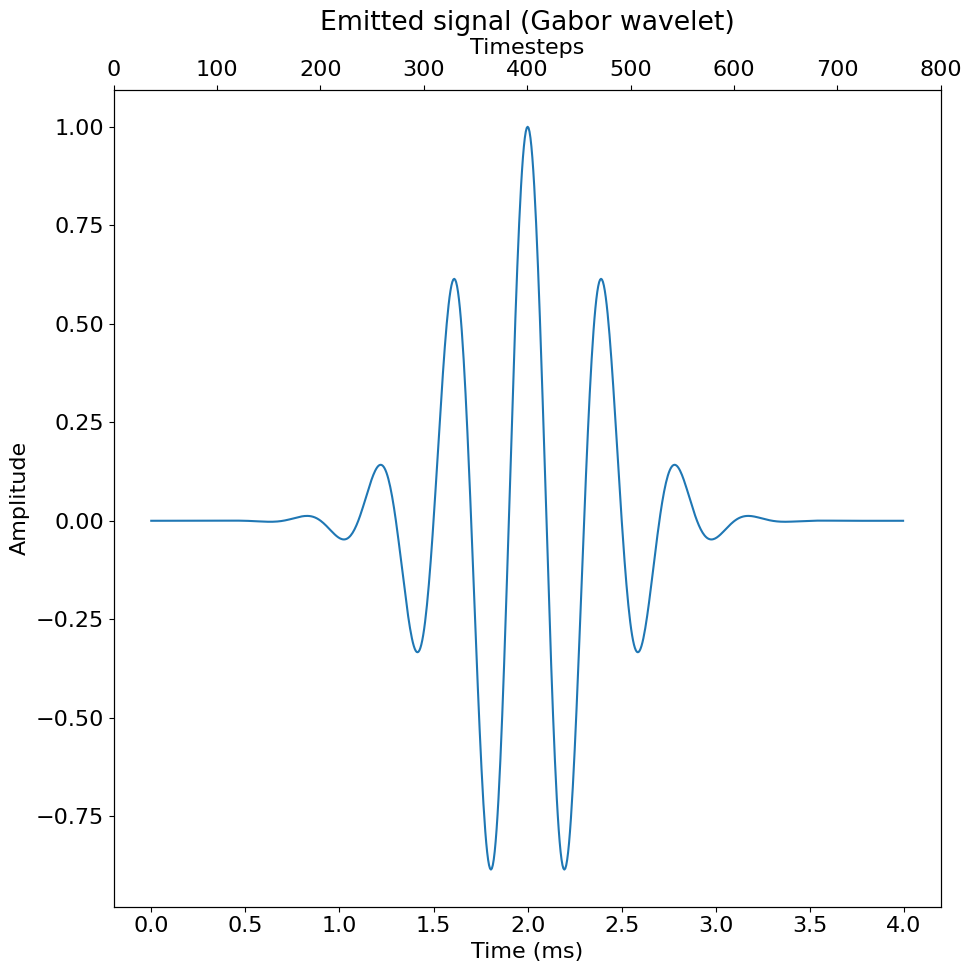

In [4]:
plot_velocity(
    sonar.model,
    source=sonar.src.coordinates.data,
    receiver=sonar.rec.coordinates.data,
)

plt.figure()
plt.plot(sonar.src.time_values[:800], sonar.src.signal_packet)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 800)
ax2.set_xlabel("Timesteps")
plt.title("Emitted signal (Gabor wavelet)")
plt.tight_layout()
plt.show()

In [5]:
recordings = {}
angles = [60,90,120]#[45, 60, 75, 90, 105, 120, 135]
for a in angles:
    sonar.run_beam(a)
    recordings[a] = copy.deepcopy(sonar.rec.data)

Allocating host memory for rec(4001, 180) [5 MB]
Allocating host memory for u(3, 1124, 1124) [29 MB]


gcc-12 -march=native -O3 -g -fPIC -Wall -std=c99 -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/696e51e7068eaf5d392d5f98b5ba5d7f3cc8431f.c -lm -o /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/696e51e7068eaf5d392d5f98b5ba5d7f3cc8431f.dylib


Operator `Kernel` jit-compiled `/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/696e51e7068eaf5d392d5f98b5ba5d7f3cc8431f.c` in 0.30 s with `GNUCompiler`
Operator `Kernel` ran in 8.39 s
Global performance: [OI=1.15, 21.67 GFlops/s, 0.59 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 1.08 GFlops/s, 0.00 GPts/s]
  * section1<3999,1108,1108> ran in 8.36 s [OI=1.15, 21.74 GFlops/s, 0.59 GPts/s]
  * section2<<3999,128,2,2>,<3999,128,2,2>> ran in 0.01 s [OI=3.00, 13.46 GFlops/s, 0.23 GPts/s]
  * section3<<3999,180>,<3999,180,2,2>> ran in 0.02 s [OI=0.66, 1.71 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 8.887224912643433 seconds


Operator `Kernel` ran in 8.40 s
Global performance: [OI=1.15, 21.65 GFlops/s, 0.59 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 1.08 GFlops/s, 0.00 GPts/s]
  * section1<3999,1108,1108> ran in 8.38 s [OI=1.15, 21.70 GFlops/s, 0.59 GPts/s]
  * section2<<3999,128,2,2>,<3999,128,2,2>> ran in 0.01 s [OI=3.00, 13.26 GFlops/s, 0.23 GPts/s]
  * section3<<3999,180>,<3999,180,2,2>> ran in 0.02 s [OI=0.66, 2.08 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 8.40728497505188 seconds


Operator `Kernel` ran in 8.40 s
Global performance: [OI=1.15, 21.65 GFlops/s, 0.59 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.36 GFlops/s, 0.00 GPts/s]
  * section1<3999,1108,1108> ran in 8.38 s [OI=1.15, 21.70 GFlops/s, 0.59 GPts/s]
  * section2<<3999,128,2,2>,<3999,128,2,2>> ran in 0.01 s [OI=3.00, 13.76 GFlops/s, 0.23 GPts/s]
  * section3<<3999,180>,<3999,180,2,2>> ran in 0.02 s [OI=0.66, 2.08 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 8.408221960067749 seconds


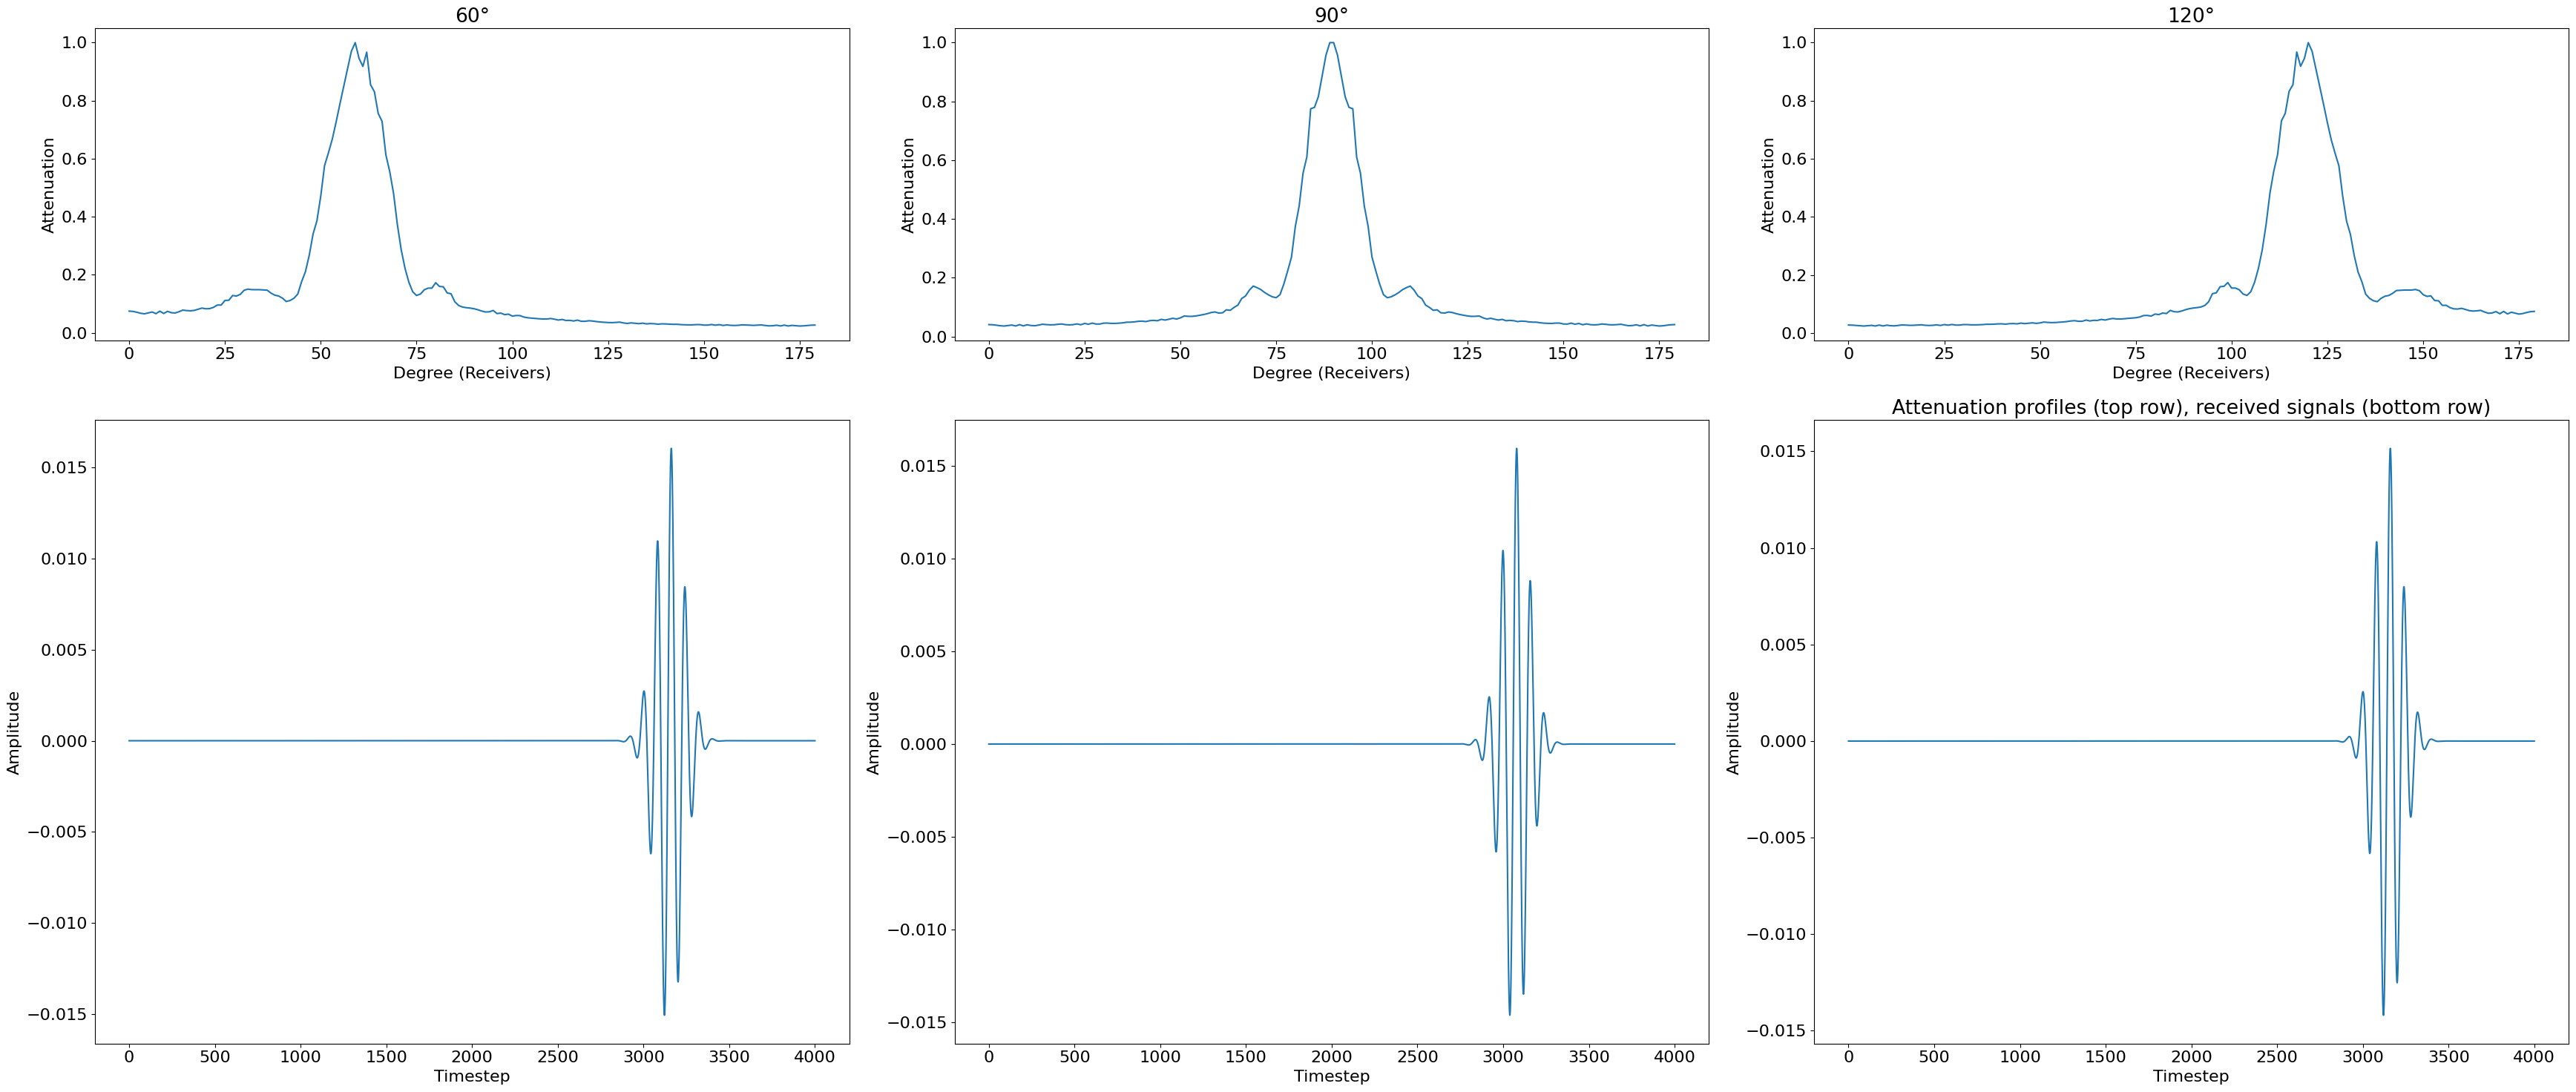

In [6]:
#Now we plot attenuation profiles and received signals
fig, ax = plt.subplots(2, 3, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
plt.title("Attenuation profiles (top row), received signals (bottom row)")
for i, (a, r) in enumerate(recordings.items()):
    recording = np.flip(r)
    ax[0, i].plot(
        np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
    )
    ax[0, i].set_xlabel("Degree (Receivers)")
    ax[0, i].set_ylabel("Attenuation")
    ax[0, i].set_title(f"{a}°")
    ax[0, i].tick_params()

    ax[1, i].plot(r[:, 180 - a])
    ax[1, i].set_xlabel("Timestep")
    ax[1, i].set_ylabel("Amplitude")
fig.tight_layout()

# Back to PPT

## Sonar - reflections

/Users/reguly/Work/sonar-FWI/notebooks


51it [00:00, 6533.58it/s]
Operator `initdamp` generated in 0.16 s
  * lowering.Clusters: 0.07 s (45.0 %)
     * specializing.Clusters: 0.04 s (25.8 %)
  * lowering.IET: 0.06 s (38.6 %)
     * specializing.IET: 0.04 s (25.8 %)
Flops reduction after symbolic optimization: [72 --> 72]


gcc-12 -march=native -O3 -g -fPIC -Wall -std=c99 -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/4732ae4e8faf070133e4d972f2fdded5fa9a28a0.c -lm -o /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/4732ae4e8faf070133e4d972f2fdded5fa9a28a0.dylib


Operator `initdamp` jit-compiled `/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/4732ae4e8faf070133e4d972f2fdded5fa9a28a0.c` in 0.36 s with `GNUCompiler`
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.10, 0.06 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<25> ran in 0.01 s [OI=0.88, 0.05 GFlops/s, 0.00 GPts/s]
  * section2<25,350> ran in 0.01 s [OI=0.69, 32.09 GFlops/s, 0.00 GPts/s]
  * section3<25> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section4<25,350> ran in 0.01 s [OI=0.69, 32.09 GFlops/s, 0.00 GPts/s]
  * section5<25> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section6<25> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section7<<650,25>,<650,25>> ran in 0.01 s [OI=0.11, 18.82 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}
Allocating host memory for vp(666, 366) [2 MB]
Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for src(12315, 128) 

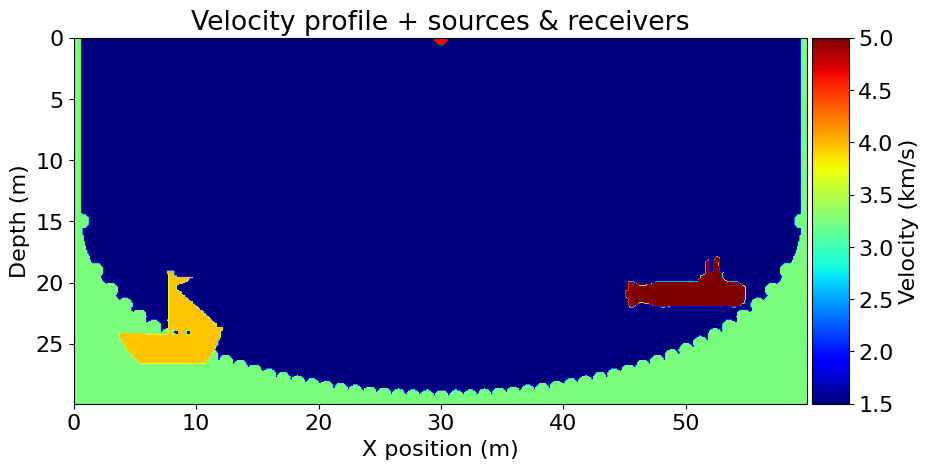

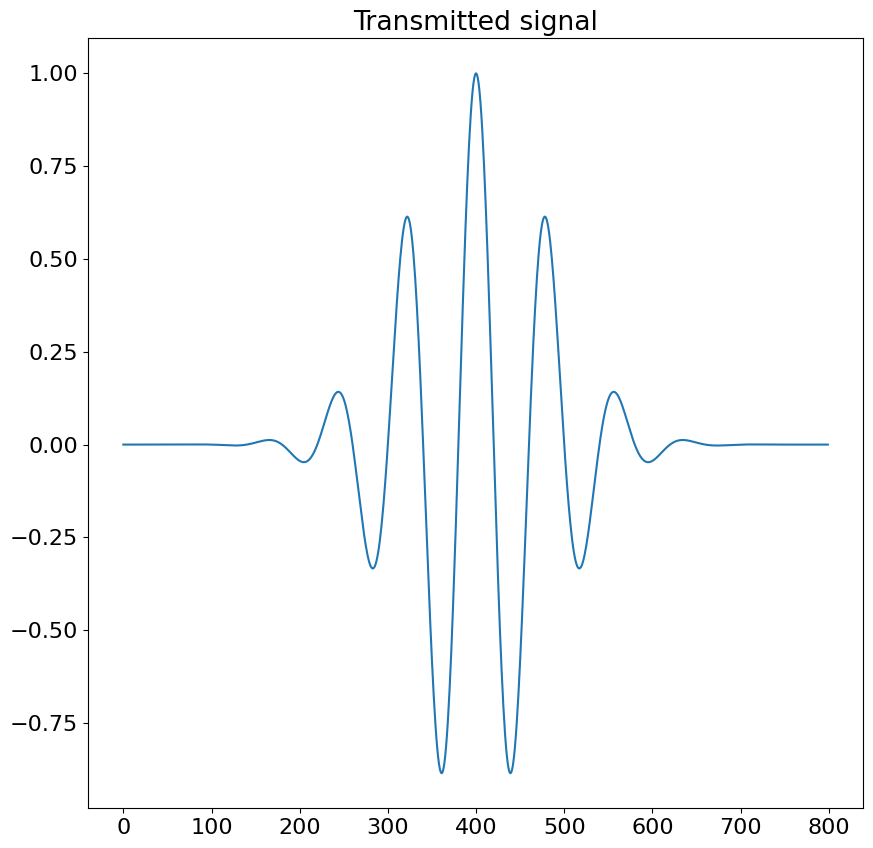

In [7]:
domain_size = (60, 30)
v_env = 1.5
source_distance = 0.02
f0 = 5
sonar = Sonar(
    domain_size,
    f0,
    v_env,
    EllipsisBottom(True), #with "bumps"
)
sonar.set_source()
sonar.set_receiver()
sonar.finalize(snapshot_delay=0.1)
plot_velocity(
    sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data
)
ideal_signal = sonar.src.signal_packet
plt.plot(ideal_signal)
plt.title("Transmitted signal")
plt.show()


Allocating host memory for rec(12315, 128) [12 MB]
Allocating host memory for u(3, 666, 366) [6 MB]
Allocating host memory for usave(616, 666, 366) [1.1 GB]


gcc-12 -march=native -O3 -g -fPIC -Wall -std=c99 -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/8da29510e703c6023ca6479497de21a6c197beb3.c -lm -o /var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/8da29510e703c6023ca6479497de21a6c197beb3.dylib


Operator `Kernel` jit-compiled `/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/devito-jitcache-uid501/8da29510e703c6023ca6479497de21a6c197beb3.c` in 0.37 s with `GNUCompiler`
Operator `Kernel` ran in 4.97 s
Global performance: [OI=0.85, 23.20 GFlops/s, 0.57 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.74 s [OI=1.26, 24.28 GFlops/s, 0.60 GPts/s]
  * section2<> ran in 0.22 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 40.41 GFlops/s, 0.68 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.02 s [OI=0.66, 5.10 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 5.857446193695068 seconds


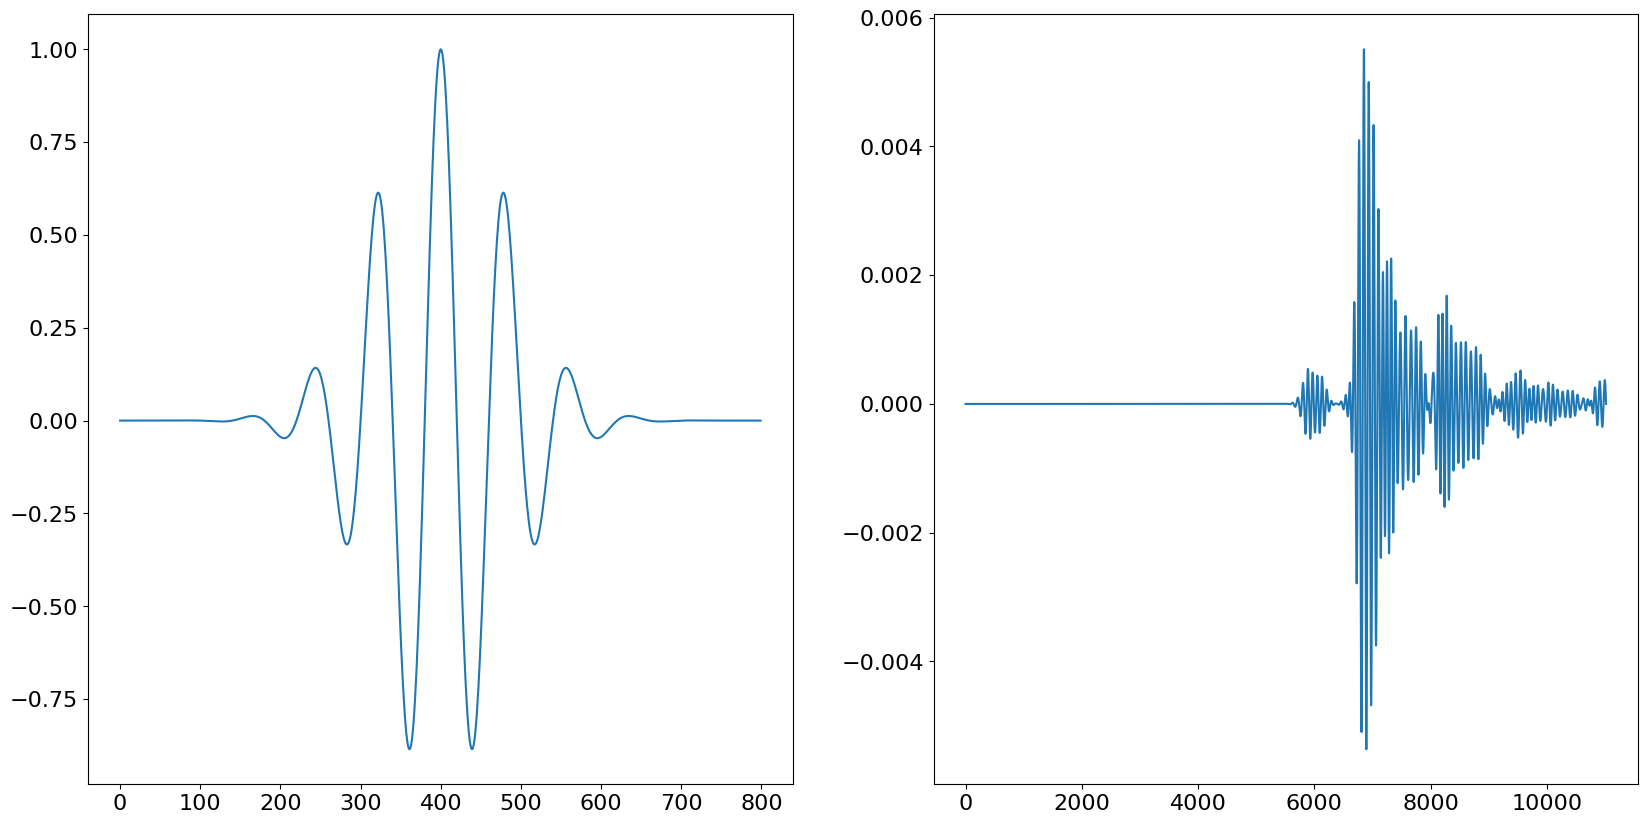

In [8]:
# Run simulation at 45 degree angle
sonar.run_beam(45)
# Copy the recording - subsequent runs overwrite it
recording_45 = copy.deepcopy(sonar.rec.data)
# Show the received signal on receiver #64
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(ideal_signal)
start_time = np.argmax(recording_45[:5000, 64])
ax[1].plot(recording_45[start_time*3:, 64])

In [9]:
# Create animations
plot_snapshot_and_signal(
    sonar.usave.data,
    recording[:, 64],
    sonar.model,
    f"snapshot.gif",
    sonar.src.coordinates.data,
    sonar.rec.coordinates.data,
)

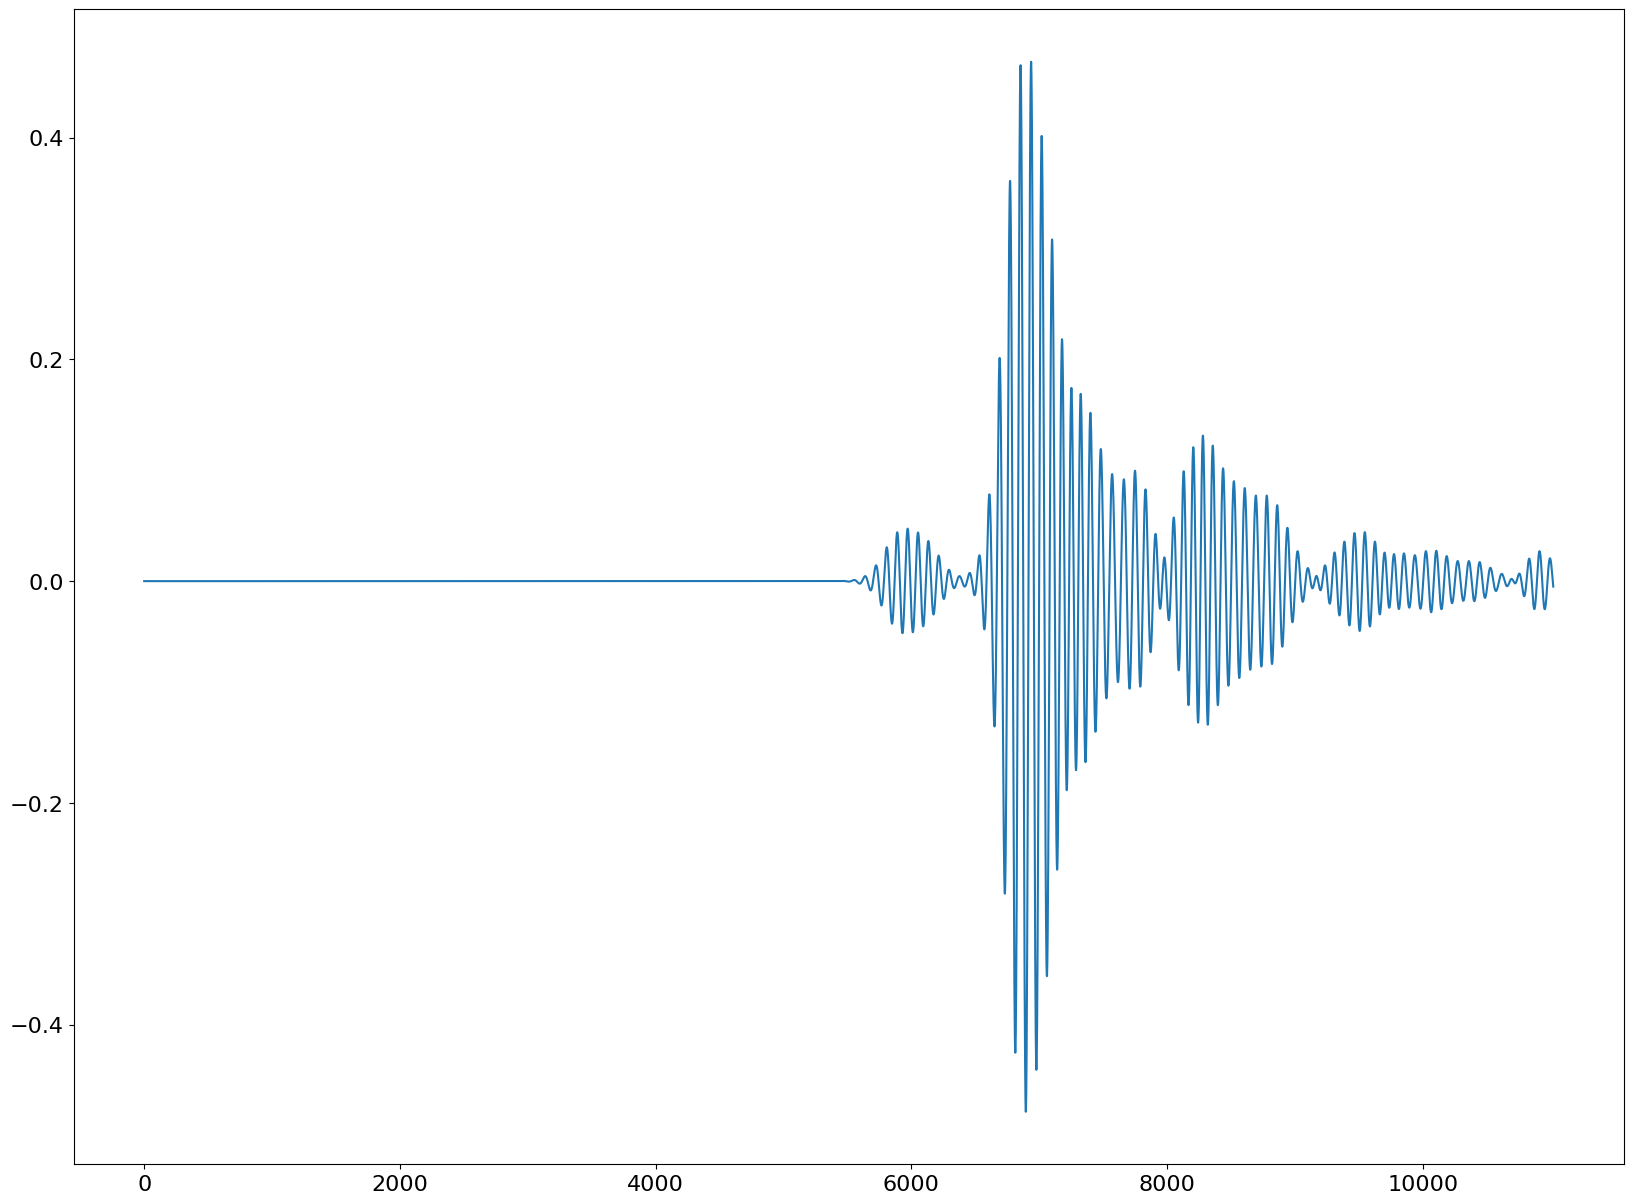

6937


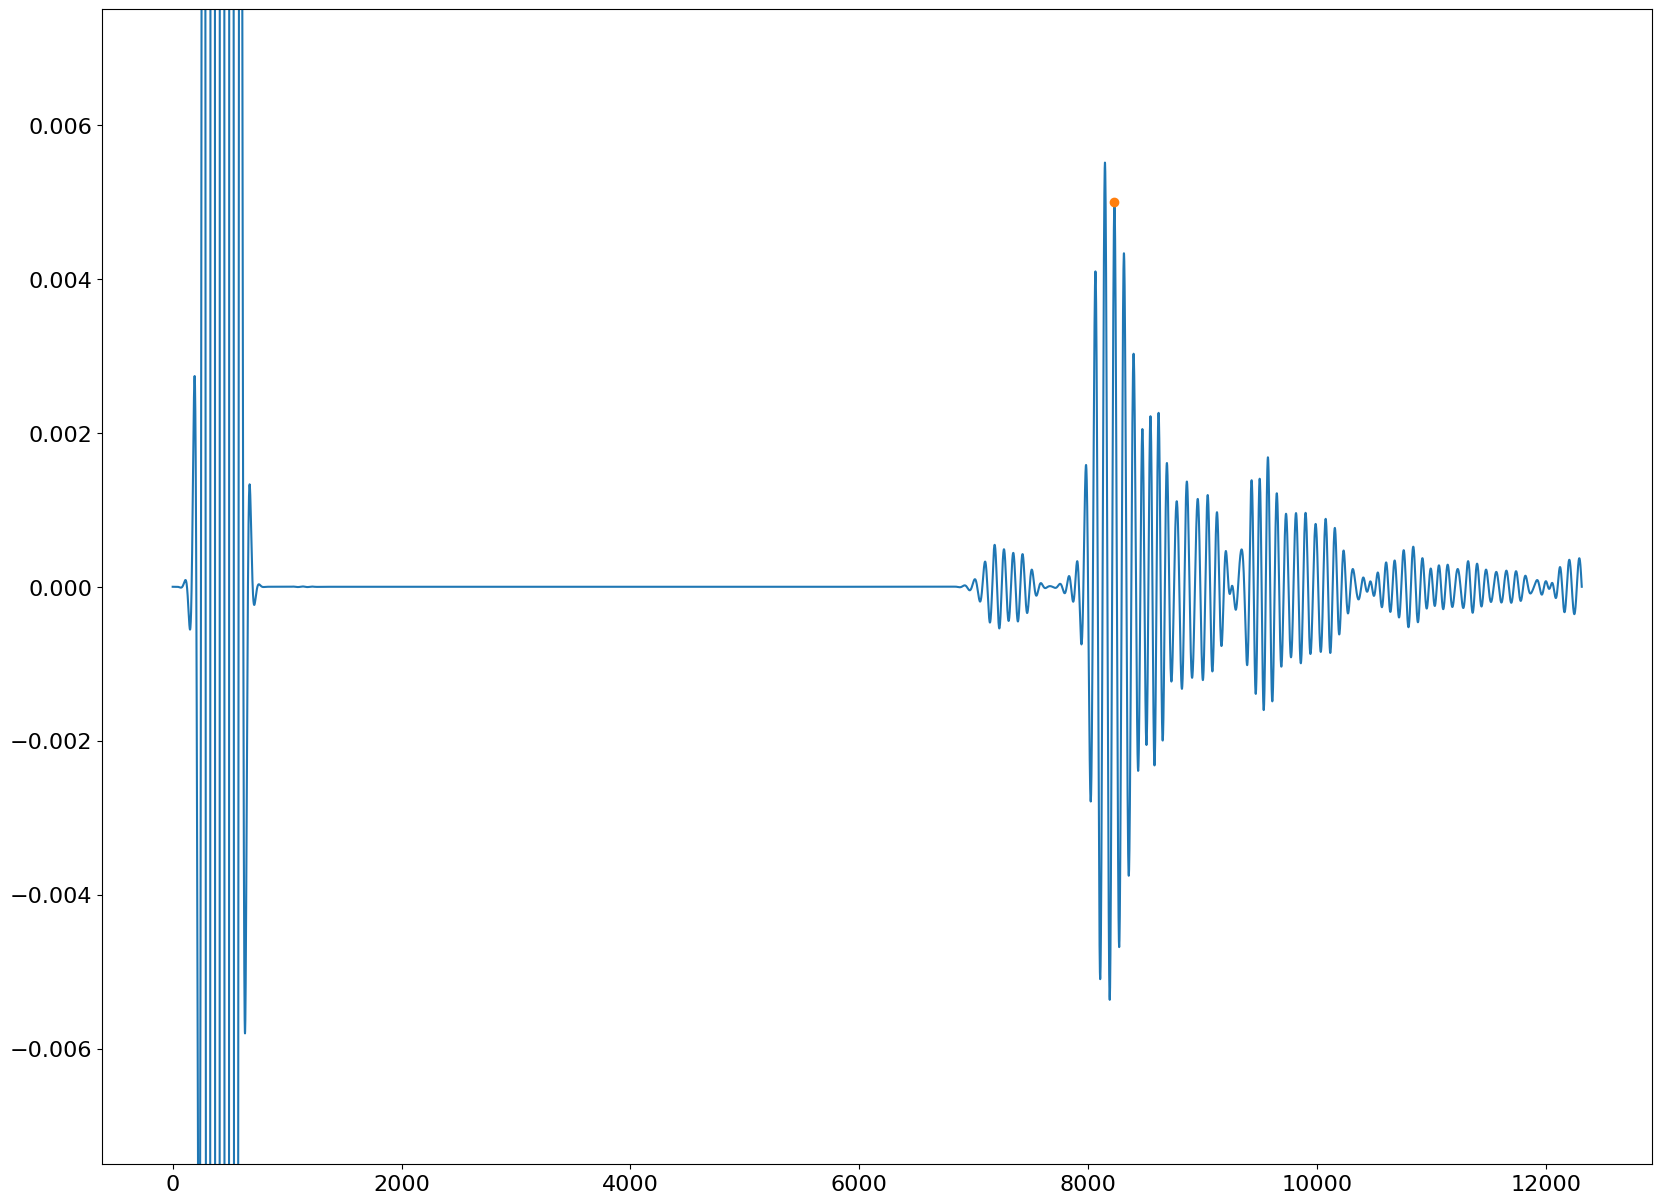

In [10]:
correlate = np.correlate(recording_45[start_time*3:, 64], ideal_signal, mode="same")
plt.figure(figsize=(20, 15))
plt.plot(correlate)
plt.show()
print(np.argmax(correlate))
peak = start_time*3 + correlate.argmax()
## change the figure size
plt.figure(figsize=(20, 15))
plt.plot(recording_45[:, 64])
plt.plot(peak, recording_45[peak, 64], "o")
plt.ylim(-1.5*recording_45[peak, 64], 1.5*recording_45[peak, 64])
plt.show()

In [11]:
distance = (peak - start_time) * sonar.model.critical_dt * v_env / 2
print(f"Distance: {distance} m")

Distance: 29.246249999999996 m


In [12]:

recordings = {}
angles = [45, 60, 75, 90, 105, 120, 135]
for a in angles:
    sonar.run_beam(a)
    recordings[a] = copy.deepcopy(sonar.rec.data)

Operator `Kernel` ran in 4.89 s
Global performance: [OI=0.85, 23.58 GFlops/s, 0.58 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.75 s [OI=1.26, 24.23 GFlops/s, 0.60 GPts/s]
  * section2<> ran in 0.12 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 40.02 GFlops/s, 0.67 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.02 s [OI=0.66, 5.64 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 4.906378984451294 seconds


Operator `Kernel` ran in 4.78 s
Global performance: [OI=0.85, 24.13 GFlops/s, 0.59 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.73 s [OI=1.26, 24.30 GFlops/s, 0.60 GPts/s]
  * section2<> ran in 0.04 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 39.93 GFlops/s, 0.67 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.01 s [OI=0.66, 9.34 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 4.7934160232543945 seconds


Operator `Kernel` ran in 4.77 s
Global performance: [OI=0.85, 24.18 GFlops/s, 0.59 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.72 s [OI=1.26, 24.38 GFlops/s, 0.60 GPts/s]
  * section2<> ran in 0.04 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 40.24 GFlops/s, 0.68 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.01 s [OI=0.66, 6.69 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 4.77988600730896 seconds


Operator `Kernel` ran in 4.83 s
Global performance: [OI=0.85, 23.88 GFlops/s, 0.58 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.78 s [OI=1.26, 24.08 GFlops/s, 0.59 GPts/s]
  * section2<> ran in 0.04 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 39.24 GFlops/s, 0.66 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.01 s [OI=0.66, 6.64 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 4.841408967971802 seconds


Operator `Kernel` ran in 4.83 s
Global performance: [OI=0.85, 23.88 GFlops/s, 0.58 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.78 s [OI=1.26, 24.05 GFlops/s, 0.59 GPts/s]
  * section2<> ran in 0.04 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 39.32 GFlops/s, 0.66 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.01 s [OI=0.66, 6.96 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 4.84434700012207 seconds


Operator `Kernel` ran in 4.83 s
Global performance: [OI=0.85, 23.88 GFlops/s, 0.58 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.77 s [OI=1.26, 24.10 GFlops/s, 0.59 GPts/s]
  * section2<> ran in 0.04 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 39.68 GFlops/s, 0.67 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.02 s [OI=0.66, 6.46 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 4.837535619735718 seconds


Operator `Kernel` ran in 4.79 s
Global performance: [OI=0.85, 24.07 GFlops/s, 0.59 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.77 GFlops/s, 0.00 GPts/s]
  * section1<12313,650,350> ran in 4.74 s [OI=1.26, 24.28 GFlops/s, 0.60 GPts/s]
  * section2<> ran in 0.04 s 
  * section3<<12313,128,2,2>,<12313,128,2,2>> ran in 0.01 s [OI=3.00, 39.49 GFlops/s, 0.66 GPts/s]
  * section4<<12313,128>,<12313,128,2,2>> ran in 0.01 s [OI=0.66, 9.50 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {}


Simulation took 4.797183036804199 seconds


In [13]:
cords = np.zeros((np.size(angles), 2))
for a, v in recordings.items():
    coordinates = np.zeros((128, 2))
    for i in range(128):
        start_time = np.argmax(recordings[a][:5000, i])
        correlate = np.correlate(recordings[a][5000:, i], ideal_signal, mode="same")
        peak = 5000 + correlate.argmax()
        distance = (
            peak - start_time
        ) * sonar.model.critical_dt * v_env / 2
        rec_coords = sonar.rec.coordinates.data[i]
        coordinates[i, 0] = rec_coords[0] - distance * np.cos(np.deg2rad(a))
        coordinates[i, 1] = rec_coords[1] + distance * np.sin(np.deg2rad(a))
    cords[list(recordings.keys()).index(a), :] = np.mean(coordinates, axis=0)    

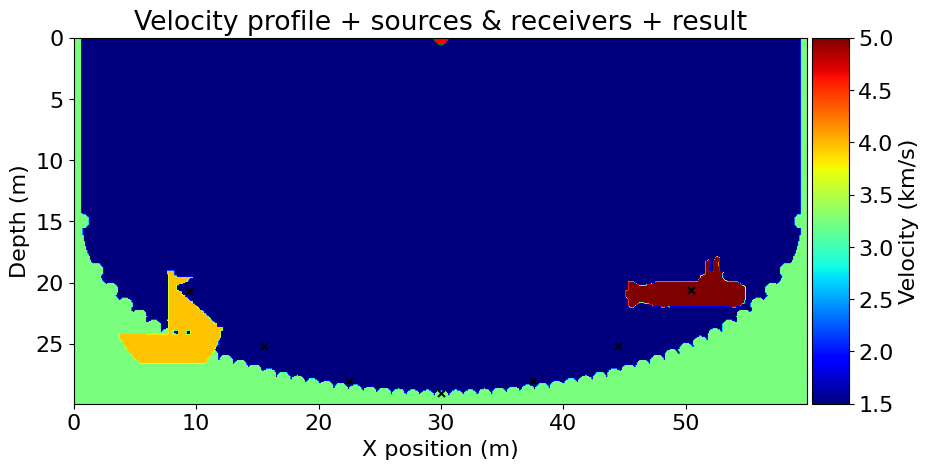

In [14]:
plot_velocity(sonar.model, sonar.src.coordinates.data, sonar.rec.coordinates.data, cords)